In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, LSTMCell, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_addons as tfa

import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import jupyterthemes as jt
from sklearn.model_selection import train_test_split
from datetime import datetime

jt.jtplot.style()

""" Avoid error with Blas:GEMM not initializing when using GPU:
See: https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
"""
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.random.set_seed(98)
np.random.seed(99)

## Exercise 8

Embedded Reber grammars were used by Hochreiter and Schmidhuber in their paper about LSTMs. They are artificial grammars that produce strings such as “BPBTSXXVPSEPE.” Check out [Jenny Orr’s nice introduction to this topic](https://www.willamette.edu/~gorr/classes/cs449/reber.html). Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr’s page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don’t.

### Generating Reber grammars

We start creating a Reber grammar generator. I'll follow the same structure provided in the link above will allow for tokens to be passed to the class to generate the strings.

Each state will be labelled as follows and has two possible transitions

![Reber Grammar](images\reber.png)

In [2]:
reber_transitions = {
    0: [(1, 'B')],
    1: [(2, 'T'), (3, 'P')],
    2: [(2, 'S'), (4, 'X')],
    3: [(3, 'T'), (5, 'V')],
    4: [(6, 'S'), (3, 'X')],
    5: [(4, 'P'), (6, 'V')],
    6: [(7, 'E')]}

def move_state(cur_state, transitions=reber_transitions):
    """Finds possible next moves in transition table and picks one at a random"""
    paths = transitions[cur_state]
    return paths[np.random.choice(len(transitions[cur_state]), size=1)[0]]
    
def generate_string(string=''):
    """Iterates over possible paths until final state is reached"""
    state = 0
    while state != 7:
        state, char = move_state(state)
        string += char
    return string

def find_next_state(cur_state, char, transitions=reber_transitions):
    """Given a current state and a character in the next state, searches transitions for a state
    with the corresponding next_char, if it exists."""
    for (next_state, next_char) in transitions[cur_state]:
        if next_char == char:
            return next_state, next_char
    return -1, -1

def validate_string(string, transitions=reber_transitions, verbose=False):
    """Iterates through a given string and checks whether the string was generated by some grammar with
    given transitions. 
    
    Probably can be improved
    """
    next_state, next_char = move_state(0, transitions)
    for idx, char in enumerate(string):
        if verbose: print(f"Next State: {next_state}; Testing {idx} : {char} vs {next_char}")
        if char != next_char:
            return 0
        try:
            if verbose: print(f"\tGoing to find next state by accessing {string[idx+1]}")
            next_state, next_char = find_next_state(next_state, string[idx+1])
            if verbose: print(f"\tReturned ({next_state}, {next_char})")
            if next_state == -1:
                return 0
        except IndexError:
            pass # Trying to access out of bounds value, meaning we reached the end of the checks
        if next_state == 7:
            break
    return 1
        

Now let's generate positive classes for our dataset and check they are valid

In [3]:
dataset_size = 10_000
reber_strings = [generate_string() for _ in range(dataset_size)]
reber_labels = [1 for _ in range(dataset_size)]

In [4]:
assert all([validate_string(reber_string) for reber_string in reber_strings]), "Some generated string is NOT REBER!"

That some sample non-reber strings are invalid

In [5]:
not_reber_tests = ['BTSSPXSE', 'BTXXVVSE', 'BPVSPSE', 'BTSSSE', 'BPTVVB']
assert not any([validate_string(not_reber) for not_reber in not_reber_tests]), "One of the test strings was identified as reber"

And let's generate a bunch of random strings and use the function above to mark them as not reber strings.

In [6]:
vocab = 'BEPSTVX'
min_length = len(min(reber_strings, key=len))
max_length = len(max(reber_strings, key=len))

# Generate N random strings with the vocab. Each time strings will have different lengths 
# that are bounded by the min/max size of the reber_lengths
randomly_generated = [''.join(np.random.choice(list(vocab), size=np.random.randint(min_length, max_length)))
                      for _ in range(dataset_size)]
randomly_gen_labels = [validate_string(random_str) for random_str in randomly_generated]

### Create datasets

In [144]:
X = np.concatenate((reber_strings, randomly_generated))
y = np.concatenate((reber_labels, randomly_gen_labels))
print(X.shape, y.shape)

(20000,) (20000,)


In [145]:
np.unique(y, return_counts=True)

(array([0, 1]), array([ 9998, 10002], dtype=int64))

Data looks balanced enough! Now let's convert it to a Tensorflow Dataset and do preprocessing

First we start with tokenizing at character level, converting the characters into numbers and creating a dataset. 

In [19]:
def create_datasets(X, y, batch_size=32):
    tokenizer = Tokenizer(char_level=True, lower=False)
    tokenizer.fit_on_texts(X)
    
    encoded = tokenizer.texts_to_sequences(X)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post', value=0) # pad with zeros
    
    # Recall RNN inputs have shape [batch_size, time_steps, dimensionality]
    # Need to reshape the data to an appropriate format
    X_full, y_full = padded[..., np.newaxis], y.reshape(-1,1)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X_full, y_full, test_size=0.05)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.05)
        
    train_set = Dataset.from_tensor_slices((X_train, y_train)).shuffle(dataset_size).batch(batch_size).prefetch(1)
    valid_set = Dataset.from_tensor_slices((X_valid, y_valid)).shuffle(dataset_size).batch(batch_size)
    test_set = Dataset.from_tensor_slices((X_test, y_test)).shuffle(dataset_size).batch(batch_size)
    return train_set, valid_set, test_set

In [21]:
train_set, valid_set, test_set = create_datasets(X, y)

### Define and train model

In [38]:
model = Sequential([
    Input(shape=[None, 1], name='Input'),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(1, activation="sigmoid")])

model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy', Precision(), Recall()])

In [39]:
with tf.device('GPU:0'):
    model.fit(train_set, epochs=15, validation_data=valid_set)

Epoch 1/15
565/565 [==============================] - 10s 12ms/step - loss: 0.4544 - accuracy: 0.7941 - precision_2: 0.7607 - recall_2: 0.8523 - val_loss: 0.3566 - val_accuracy: 0.8505 - val_precision_2: 0.8307 - val_recall_2: 0.8828
Epoch 2/15
565/565 [==============================] - 6s 10ms/step - loss: 0.3806 - accuracy: 0.8277 - precision_2: 0.7829 - recall_2: 0.9020 - val_loss: 0.2004 - val_accuracy: 0.9326 - val_precision_2: 0.8966 - val_recall_2: 0.9791
Epoch 3/15
565/565 [==============================] - 6s 11ms/step - loss: 0.2347 - accuracy: 0.9103 - precision_2: 0.8704 - recall_2: 0.9624 - val_loss: 0.1610 - val_accuracy: 0.9516 - val_precision_2: 0.9303 - val_recall_2: 0.9770
Epoch 4/15
565/565 [==============================] - 6s 11ms/step - loss: 0.1466 - accuracy: 0.9560 - precision_2: 0.9276 - recall_2: 0.9901 - val_loss: 0.1188 - val_accuracy: 0.9674 - val_precision_2: 0.9443 - val_recall_2: 0.9937
Epoch 5/15
565/565 [==============================] - 6s 11ms/step 

### Evaluate

In [40]:
loss, acc, pre, rec = model.evaluate(test_set)

32/32 [==============================] - 0s 6ms/step - loss: 0.0092 - accuracy: 0.9990 - precision_2: 0.9980 - recall_2: 1.0000


# Exercise 9

Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from “April 22, 2019” to “2019-04-22”).

Let's first generate the dataset

### Data Creation

In [2]:
df = pd.DataFrame({"source":np.arange('1900-01-01', '2021-01-01', dtype='datetime64[D]')})
df["X"] = df["source"].dt.strftime("%B %d, %Y")
df["y"] = df["source"].dt.strftime("%Y-%m-%d")
df = df.sample(frac=1.)  # Resample the dataframe to shuffle the dates

X = df["X"].to_numpy()
y = df["y"].to_numpy()
df.tail()

,source,X,y
34536,1994-07-23,"July 23, 1994",1994-07-23
42697,2016-11-25,"November 25, 2016",2016-11-25
36008,1998-08-03,"August 03, 1998",1998-08-03
23587,1964-07-31,"July 31, 1964",1964-07-31
29313,1980-04-04,"April 04, 1980",1980-04-04


### Tokenizing

With the data already cleansed, we can tokenize both X and y with the same object. The `<sos>` and `<eos>` tokens will have ids 0 and 1 respectively.

Since we'll be outputting probabilities and our targets are words, we have no way of calculating metrics during training (maybe?). Thus I'll use a very small test size

*We also have to shift the decoder inputs by 1 so the words we give as inputs are the words that it **should** have output at the previous step* - Not so sure

In [3]:
input_vocab = sorted(list(set(word for entry in X for word in entry)))
output_vocab = sorted(list(set(word for entry in y for word in entry)))

In [4]:
def tokenize_sent(sent, vocab):
    """Converts characters to ints by using char's index """
    return [vocab.index(char) for char in sent]

def encode_data(data, vocab):
    """Tokenize list of sentence and converts them to a dense tensor padded
    with zeroes."""
    ids = [tokenize_sent(sent, vocab) for sent in data]
    data = tf.ragged.constant(ids, ragged_rank=1)
    return (data + 1).to_tensor() # Padding token will have id 0

def decode_sequence(seq, vocab):
    return ''.join(vocab[char_id - 1] for char_id in seq)

In [5]:
X_encoded = encode_data(X, input_vocab)
y_encoded = encode_data(y, output_vocab)

In [6]:
print("X : ", X[:1])
print("X encoded: ", X_encoded[:1])
print("X decoded: ", decode_sequence(X_encoded[:1].numpy()[0], input_vocab))

X :  ['July 31, 1939']
X encoded:  tf.Tensor([[16 36 28 38  1  6  4  2  1  4 12  6 12  0  0  0  0  0]], shape=(1, 18), dtype=int32)
X decoded:  July 31, 1939yyyyy


In [7]:
# Train, validation, test split
train_size = len(X_encoded) * 80 // 100
test_size = (len(X_encoded) - train_size) // 2

X_train, y_train = X_encoded[:train_size], y_encoded[:train_size]
X_valid, y_valid = X_encoded[train_size:train_size + test_size], y_encoded[train_size:train_size + test_size]
X_test, y_test = X_encoded[train_size + test_size:], y_encoded[train_size + test_size:]

In [8]:
BATCH_SIZE = 32
EMBED_SIZE = 8
MAX_OUTPUT_LEN = y_train.shape[1]
sos_id = len(output_vocab) + 1 # adding a start of sequence token for the shifted decoder inputs

def get_sequence_lengths(y):
    return np.full([y.shape[0]], y_train.shape[1])

def shift_sequence(y, fill=sos_id):
    """Shifts target out by 1 to generate decoder inputs with a start of sequence token"""
    return np.c_[np.full((len(y), 1), fill), y[:, :-1]]

def create_dataset(X, y, batch_size=BATCH_SIZE):
    input_ = Dataset.zip((
        Dataset.from_tensor_slices(X), # Encoder inputs
        Dataset.from_tensor_slices(shift_sequence(y)))) # Decoder inputs
    target = Dataset.from_tensor_slices(y)
    return Dataset.zip((input_, target)).shuffle(len(X)).batch(batch_size)
    
train_set = create_dataset(X_train, y_train).prefetch(1)
valid_set = create_dataset(X_valid, y_valid)
test_set = create_dataset(X_test, y_test)

### Creating Model

For this Encoder-Decoder Network, we'll be using [tensorflow-addons](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt)

In [187]:
encoder_inputs = Input(shape=[None], dtype=np.int32, name='encoder_inputs')
decoder_inputs = Input(shape=[None], dtype=np.int32, name='decoder_inputs')
sequence_lengths = Input(shape=[], dtype=np.int32, name='sequence_lengths')

# Add 1 to the Embed dimension due to using 0 padding
encoder_embedding_layer = Embedding(len(input_vocab) + 1, EMBED_SIZE, name='encoder_embedding')
# And an extra 1 for the SoS token
decoder_embedding_layer = Embedding(len(input_vocab) + 2, EMBED_SIZE, name='decoder_embedding')

encoder_embeddings = encoder_embedding_layer(encoder_inputs)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = LSTMCell(64)
output_layer = Dense(len(output_vocab) + 1) # Zero padding
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler, output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(decoder_embeddings,
                                                             initial_state=encoder_state)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = Model(inputs=[encoder_inputs, decoder_inputs],
              outputs=[Y_proba],
              name='date_translator')
model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam', metrics=['accuracy'])
model.summary()

Model: "date_translator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 8)      312         encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 8)      320         decoder_inputs[0][0]             
____________________________________________________________________________________

In [188]:
# setup for tensorboard
import os
from pathlib import Path

fpath = './my_logs/date_translator'
Path(fpath).mkdir(parents=True, exist_ok=True)
root_logdir = os.path.join(os.curdir, fpath)

def get_run_logdir():
    import time
    run_id = f"char_model_batch_size_{BATCH_SIZE}_embed_dim_{EMBED_SIZE}"
    run_id += time.strftime("_%Y_%m_%d-%H")
    return os.path.join(root_logdir, run_id)

callbacks = [TensorBoard(get_run_logdir())]

In [189]:
import os
from tensorboard.plugins import projector

def get_last_modified_folder(loc='./my_logs/date_translator/'):
    files = os.listdir(loc)
    stats = [(loc+fname, os.stat(loc+fname).st_mtime) for fname in files]
    return max(stats, key=lambda x: x[1])[0]

def save_embeddings(embed_layer, name, vocab):
    logdir = get_last_modified_folder()
    with open(os.path.join(logdir, f'{name}_metadata.tsv'), "w") as f:
        for word in vocab:
            f.write(f"{word}\n")
    
    weights = tf.Variable(embed_layer.get_weights()[0])
    checkpoint = tf.train.Checkpoint(embedding=weights)
    checkpoint.save(os.path.join(logdir, f"{name}.ckpt"))
    
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = f"{name}/.ATTRIBUTES/TEST_VALUE"
    embedding.metadata_path = f'{name}_metadata.tsv'
    projector.visualize_embeddings(logdir, config)

In [190]:
with tf.device('CPU:0'):
    model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=callbacks)

Epoch 1/5
1105/1105 [==============================] - 29s 23ms/step - loss: 1.4171 - accuracy: 0.4975 - val_loss: 0.8316 - val_accuracy: 0.6834
Epoch 2/5
1105/1105 [==============================] - 18s 16ms/step - loss: 0.7613 - accuracy: 0.7098 - val_loss: 0.5143 - val_accuracy: 0.8024
Epoch 3/5
1105/1105 [==============================] - 18s 17ms/step - loss: 0.4084 - accuracy: 0.8552 - val_loss: 0.1634 - val_accuracy: 0.9625
Epoch 4/5
1105/1105 [==============================] - 18s 17ms/step - loss: 0.1260 - accuracy: 0.9730 - val_loss: 0.0427 - val_accuracy: 0.9948
Epoch 5/5
1105/1105 [==============================] - 18s 17ms/step - loss: 0.0326 - accuracy: 0.9969 - val_loss: 0.0129 - val_accuracy: 0.9999


Save the embeddings to examine in TensorBoard

In [60]:
embed_layer = model.layers[2]
save_embeddings(embed_layer, embed_layer.name, input_vocab)

embed_layer = model.layers[3]
save_embeddings(embed_layer, embed_layer.name, output_vocab)

### Testing performance

Earlier I was trying to generate predictions by simply passing the encoder input (X) shifted to the decoder. Naturally, this was not working as intended. The approach below does the prediction step by step by changing the decoder inputs at each iteration and using that to generate the next character.

In [159]:
def make_predictions(dates, sos_id=len(output_vocab)+1):
    """Generates predictions, one character at a time. 
    
    We start with passing SoS character to the decoder, generating a prediction,
    appending that to decoder input and so on, until MAX_LEN is reached. 
    """
    X = encode_data(dates, input_vocab)
    y = tf.fill((len(X), 1), sos_id) 
    for index in range(MAX_OUTPUT_LEN):
        pad_size = MAX_OUTPUT_LEN - y.shape[1]
        X_decoder = tf.pad(y, [[0, 0], [0, pad_size]])
        y_pred_probas = model.predict((X, X_decoder))[:, index:index+1]
        y_pred = tf.argmax(y_pred_probas, axis=-1, output_type=tf.int32)
        y = tf.concat([y, y_pred], axis=1)
    return [decode_sequence(translated, output_vocab) for translated in y[:, 1:].numpy()]

In [177]:
actual = X[train_size + test_size:]
translated = make_predictions(actual)
result_df = pd.DataFrame({"actual": actual, "translation": translated})
result_df.head(20)

,actual,translation
0,"May 20, 2018",2018-05-20
1,"October 28, 2009",2009-10-28
2,"June 16, 1936",1936-06-16
3,"September 22, 1954",1954-09-22
4,"June 21, 1984",1984-06-21
5,"July 06, 1949",1949-07-06
6,"September 08, 1921",1921-09-08
7,"November 23, 1943",1943-11-23
8,"December 08, 1970",1970-12-08
9,"January 21, 1911",1911-01-21


Results look good! There's an issue however; Because the model was trained on data ranging from years ranging from 1900 to 2021, it does not perform well when given an year out of that range.

In [180]:
make_predictions(['July 18, 1444', 'September 12, 1234'])

['2014-07-11', '2013-17-12']

### Using GreedyEmbeddingSampler
The [notebook](https://github.com/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb) points out that by using `GreedyEmbeddingSampler` as sampler, we can speed up prediction time. 

It does this by calculating the decoder outputs argmax, running the resulting token IDs through the decoder embedding layer then feeding these results to the decoder cell at the next time step. This also eliminates the need for us to pass the shifted decoder inputs as well. 

Below is an implementation of this model

In [206]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=MAX_OUTPUT_LEN) # Avoids infinite loops

batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = Model(inputs=[encoder_inputs], 
                        outputs=[final_outputs.sample_id]) # Use final_outputs.rnn_output if we want logits
inference_model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])

In [214]:
def speedy_predictions(dates):
    X = encode_data(dates, input_vocab)
    y = inference_model.predict(X)
    return [decode_sequence(translated, output_vocab) for translated in y]

Let's compare the two

In [216]:
%timeit make_predictions(actual)

30.2 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [217]:
%timeit speedy_predictions(actual)

4.4 s ± 34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Exercise 10

Go through [Neural Machine Translation with Attention tutorial](https://homl.info/nmttuto) - Done, I'd like to try to implement attention for the date problem above:

We start by re-defining the Encoder in a class of its own

In [9]:
class Encoder(tf.keras.models.Model):
    def __init__(self, units, vocab_size, embedding_dim, batch_size):
        super(Encoder, self).__init__()
        self.units = units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        
        self.embedding = Embedding(self.vocab_size, self.embedding_dim)
        self.lstm = LSTM(self.units, return_sequences=True, return_state=True)
        
    def call(self, X, hidden):
        X = self.embedding(X)
        encoder_outputs, state_h, state_c = self.lstm(X)
        return encoder_outputs, [state_h, state_c]
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [10]:
encoder = Encoder(64, len(input_vocab)+1, EMBED_SIZE, BATCH_SIZE)

In [11]:
hidden = encoder.initialize_hidden_state()
sample_input = next(iter(Dataset.from_tensor_slices(X_train).batch(32)))
encoder_out, encoder_state = encoder(sample_input, hidden)

print(f"Encoder output shape (batch_size, time_steps, units) {encoder_out.shape}")
print(f"Encoder state shape (batch_size, units) {encoder_state[0].shape}")

Encoder output shape (batch_size, time_steps, units) (32, 18, 64)
Encoder state shape (batch_size, units) (32, 64)


The output of the attention mechanism is 
$$ \overline{\textbf{h}}_{(t)} = \sum_{i}\alpha_{(t,i)}\textbf{y}_{(i)}$$
Where $\textbf{y}_{(i)}$ are the outputs of the encoder at time step *i* and
$$ \alpha_{(t,i)} = \frac{\exp(e_{(t,i)})}{\sum_{i'}\exp(e_{(t,i')})}$$
Are the weights of the *i-th* encoder output at decoder time step *t*.

$e_{(t,i)}$ is the energy score for each encoder output given by
$$ e_{(t,i)} = 
\begin{cases}
    \textbf{h}_{(t)}^{\intercal}\textbf{y}_{(i)} & & \text{dot (Luong)} \\
    \textbf{v}^{\intercal}\tanh(\textbf{W}[\textbf{h}_{(t)}; \textbf{y}_{(i)}]) & & \text{additive (Bahdanau)}
\end{cases}
$$

In [223]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(LuongAttention, self).__init__(**kwargs)
        self.units = units
        self.fc = Dense(1) # Initial TimeDistributed Dense layer
        
    def call(self, encoder_outputs, hidden):
        # Hidden layer has shape (batch_size, units)
        # Need to expand it to (batch_size, 1, units)
        # So it has the same shape as encoder_outputs
        hidden = tf.expand_dims(hidden, axis=1)
        
        # LuongAttention used dot product
        score = self.fc(encoder_outputs * hidden)
#         score = encoder_outputs * hidden
        
        # Softmax along axis 1 which is the time_steps axis
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = tf.reduce_sum(attention_weights * encoder_outputs, axis=1)
        return context_vector, attention_weights

In [224]:
attention = LuongAttention(64)
# decoder_inputs, attention_weights = attention(encoder_out, hidden)
decoder_inputs, attention_weights = attention(encoder_out, tf.random.normal(shape=hidden.shape))

print(f"Attention output shape (batch_size, units) {decoder_inputs.shape}")
print(f"Attention weights shape (batch_size, units) {attention_weights.shape}")

Attention output shape (batch_size, units) (32, 64)
Attention weights shape (batch_size, units) (32, 18, 1)


In [325]:
class Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, batch_size):
        super(Decoder, self).__init__()
        self.units = units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        
        self.embedding = Embedding(self.vocab_size, self.embedding_dim)
        self.lstm = LSTM(self.units, return_sequences=True, return_state=True)
        self.attention = LuongAttention(self.units)
        self.fc = Dense(vocab_size)
    
    def call(self, X, encoder_output):
        X = self.embedding(X)
        X, state_h, state_c = self.lstm(X)
        X = tf.reshape(X, (-1, X.shape[2]))
        
        context_vector, attention_weights = self.attention(encoder_output, state_h)
        X = tf.concat([context_vector, X], axis=-1)  # Concat attention vector
        
        # Remove axis 1 from LSTM output which corresponds to time_steps
        y = self.fc(X)
        return y, state_h, attention_weights

In [342]:
loss=0
for t in range(1, y.shape[1]):
    y_pred_probas, state, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), encoder_out)
    loss += loss_function(y[:, t], y_pred_probas)

    # Next input will be what decoder should
    # have predicted in the previous time step
    decoder_input = tf.expand_dims(y[:, t], 1)

In [329]:
decoder = Decoder(64, len(output_vocab), EMBED_SIZE, BATCH_SIZE)
decoder_output, state, attn_weights = decoder(tf.random.uniform((BATCH_SIZE, 1)), encoder_out)

print(f"Decoder output shape (batch_size, vocab_size) {decoder_output.shape}")

Decoder output shape (batch_size, vocab_size) (32, 11)


In [322]:
optimizer = Nadam()
loss_obj = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_ = loss_obj(y_true, y_pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [355]:
@tf.function
def train_step(X, y, encoder_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        encoder_out, encoder_state = encoder(X, encoder_hidden)
        decoder_hidden = encoder_hidden
        decoder_input = tf.expand_dims([sos_id] * BATCH_SIZE, 1)  #initial decoder_input
        
        for t in range(1, y.shape[1]):
            y_pred_probas, state, _ = decoder(decoder_input, encoder_out)
            loss += loss_function(y[:, t], y_pred_probas)
            
            # Next input will be what decoder should
            # have predicted in the previous time step
            decoder_input = tf.expand_dims(y[:, t], 1)
    batch_loss = (loss / int(y.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [356]:
EPOCHS = 5
BATCH_SIZE = 32
steps_per_epoch = len(X_train)//BATCH_SIZE
BUFFER_SIZE = len(X_train)
EMBED_SIZE = 8
units = 64

train_set = Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

encoder = Encoder(units, len(input_vocab)+1, EMBED_SIZE, BATCH_SIZE)
attention = LuongAttention(units)
decoder = Decoder(units, len(output_vocab)+2, EMBED_SIZE, BATCH_SIZE)

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch_no, (X, y)) in enumerate(train_set.take(steps_per_epoch)):
        batch_loss = train_step(X, y, enc_hidden)
        total_loss += batch_loss
        
        if batch_no % 100 == 0:
            print(f"Epoch {epoch+1} Batch {batch_no} Loss {batch_loss.numpy():.4f}")
            
    print(f"Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}")
    print(f"Time taken for 1 epoch {time.time() - start} sec\n")

Epoch 1 Batch 0 Loss 2.3082
Epoch 1 Batch 100 Loss 1.7554
Epoch 1 Batch 200 Loss 1.5025
Epoch 1 Batch 300 Loss 1.4424
Epoch 1 Batch 400 Loss 1.4625
Epoch 1 Batch 500 Loss 1.4119
Epoch 1 Batch 600 Loss 1.3153
Epoch 1 Batch 700 Loss 1.2632
Epoch 1 Batch 800 Loss 1.2608
Epoch 1 Batch 900 Loss 1.2119
Epoch 1 Batch 1000 Loss 1.1806
Epoch 1 Batch 1100 Loss 1.1076
Epoch 1 Loss 1.4051
Time taken for 1 epoch 50.86403679847717 sec

Epoch 2 Batch 0 Loss 1.1256
Epoch 2 Batch 100 Loss 0.9781
Epoch 2 Batch 200 Loss 0.9926
Epoch 2 Batch 300 Loss 0.8683
Epoch 2 Batch 400 Loss 0.8034
Epoch 2 Batch 500 Loss 0.6425
Epoch 2 Batch 600 Loss 0.6130
Epoch 2 Batch 700 Loss 0.5591
Epoch 2 Batch 800 Loss 0.5089
Epoch 2 Batch 900 Loss 0.5333
Epoch 2 Batch 1000 Loss 0.5010
Epoch 2 Batch 1100 Loss 0.4516
Epoch 2 Loss 0.7086
Time taken for 1 epoch 38.62775254249573 sec

Epoch 3 Batch 0 Loss 0.3969
Epoch 3 Batch 100 Loss 0.4221
Epoch 3 Batch 200 Loss 0.3767
Epoch 3 Batch 300 Loss 0.3874
Epoch 3 Batch 400 Loss 0.3233


In [357]:
max_input_len = X_train.shape[1]
max_output_len = y_train.shape[1]
output_vocab_ = ['<sos>'] + output_vocab

def evaluate(date):
    attn_plot = np.zeros((max_output_len, max_input_len))
    X = encode_data(date, input_vocab)
    X = pad_sequences(X, padding='post', maxlen=max_input_len)
    print(X.shape)
    result = ''
    
    hidden = [tf.zeros((1, units))]
    encoder_output, state = encoder(X, hidden)
    decoder_input = tf.expand_dims([sos_id], 0)  #initial decoder_input
    for t in range(max_output_len):
        y_pred_probas, state, attn_weights = decoder(decoder_input, encoder_output)
        
        attn_weights = tf.reshape(attn_weights, (-1,))
        attn_plot[t] = attn_weights.numpy()
        
        y_pred = tf.argmax(y_pred_probas[0]).numpy()
#         return y_pred_probas
        result += output_vocab_[y_pred]
        
        # Feed the prediction back to the model
        decoder_input = tf.expand_dims([y_pred], 0)
    return result, X, attn_plot

In [358]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + [c for c in sentence], fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + [c for c in predicted_sentence], fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [359]:
sent = ["December 18, 1992"]
result, X, attn_plot = evaluate(sent)
print(result)

(1, 18)
92-12-12-1


<ipython-input-358-cffcad780413>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [c for c in sentence], fontdict=fontdict, rotation=90)
<ipython-input-358-cffcad780413>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [c for c in predicted_sentence], fontdict=fontdict)


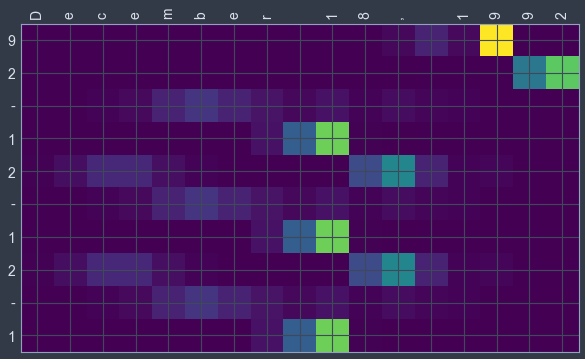

In [360]:
plot_attention(attn_plot[:len(result), :len(sent[0])], sent[0], result)

Obviously the result isn't coming out correctly, though i'm not sure where I'm going wrong here.

# Exercise 11
Use one fo the recent Language Models to generate more convincing Shakesperean text

For this I'll use [HuggingFace Transformers](https://huggingface.co/transformers/)

In [129]:
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from transformers import tf_top_k_top_p_filtering, pipeline
from pprint import pprint

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = TFGPT2LMHeadModel.from_pretrained("gpt2")

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


### Data

In [157]:
text = "First, you know Caius Marcius is chief enemy to the people."
max_len = 200
temp = 0.6

tokenized = tokenizer(text, add_special_tokens=False, return_tensors="tf")
input_ids = tokenized.input_ids
attn_mask = tokenized.attention_mask

output = model.generate(
    input_ids=input_ids,
    attention_mask=attn_mask,
    do_sample=True,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.1,
    max_length=max_len,
    temperature=temp)

print(f"{text} ... {tokenizer.decode(output[0])[len(text):]}")

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


First, you know Caius Marcius is chief enemy to the people. ...  He has been imprisoned for his treason and he will be executed if we do not destroy him before then."
The king's words were a little harsh but they also made me think about what might happen in our own country after that war ended (which was probably as soon as it began). I'm glad my father died long ago so this time around there are some things which may change: one day all of us who have served with Nerva or other princes should die fighting because their family became enemies! The next year when these guys start getting shot at again by bandits just imagine how much more dangerous life would become than being killed on your way home from work each morning while trying desperately hard to get back into civilization without any help whatsoever… This could possibly lead to something worse like mass murder? Or maybe even genocide!? It seems such an unlikely scenario either... Even though many nobles simply refuse to go alo